## Analyzing Traffic Congestion, Speeding, and Accident Correlation  
**Authored by:** Sabih Ul Hassan  

**Duration:** 90 minutes 
**Level:** Intermediate  
**Pre-requisite Skills:** Python, Data Analysis, Exploratory Data Analysis (EDA), Geospatial Visualization, Statistical Analysis, Feature Engineering, Clustering  

### Scenario

In this project, I am tasked with understanding the correlation between traffic congestion, speeding incidents, and road accidents. The goal is to analyze historical traffic and accident data to extract meaningful patterns, identify high-risk areas, and develop strategies to improve road safety and traffic management. This project involves exploring traffic speed, road geometry, accident severity, and the influence of environmental factors such as light conditions on accident occurrences.

### What this use case will teach you

At the end of this use case, you will:
- Understand how to clean and preprocess traffic and accident datasets.
- Perform exploratory data analysis (EDA) to extract key insights from traffic and accident data.
- Apply clustering techniques to identify high-risk roads and accident-prone areas.
- Conduct temporal analysis to explore how traffic patterns and accidents vary by time of day and day of the week.
- Analyze the correlation between speeding incidents and accident severity.
- Compare accident patterns across different speed zones and road geometries.
- Provide strategic recommendations to optimize traffic flow and reduce accident rates.
- Develop actionable recommendations for improving road safety and managing traffic congestion.

### Background and Introduction

Traffic congestion and road accidents are major challenges for cities around the world. By leveraging historical traffic data, city planners and traffic management authorities can make data-driven decisions to improve road safety and traffic flow. This project focuses on analyzing the relationship between traffic congestion, speeding incidents, and accidents. By identifying trends and high-risk areas, this analysis aims to propose strategies that reduce accident rates and enhance overall traffic management efficiency. Additionally, the correlation between road design, environmental factors, and accident severity will be explored, offering valuable insights for targeted interventions.

### Datasets Used

1. **Historical Traffic Data (Speed and Congestion)**: This dataset contains information about traffic speed, vehicle classifications, and speed limits across different roads and time periods.
2. **Accident Dataset**: This dataset includes accident details such as severity, road geometry, number of vehicles involved, light conditions, and speed zones.

These datasets have been carefully cleaned and processed to ensure accuracy and consistency in the analysis.


## Importing Datasets

This section loads the accident and traffic datasets and examines their structure and summary statistics.


In [1]:
import requests
import pandas as pd
import os
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [2]:
def API_Unlimited(datasetname): # pass in dataset name and api key
    dataset_id = datasetname

    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = api_key
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC'
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        datasetname = pd.read_csv(StringIO(url_content), delimiter=';')
        print(datasetname.sample(10, random_state=999)) # Test
        return datasetname 
    else:
        return (print(f'Request failed with status code {response.status_code}'))


# Function to fetch data from a URL
def fetch_data_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = pd.read_csv(StringIO(response.content.decode('utf-8')))
        print(data.head())  # Display the first few rows for verification
        return data
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

# URL for the road crash data
crash_data_url = 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Road_Safety/ACCIDENT.csv'



In [3]:
download_link_1 = 'traffic-count-vehicle-classification-2014-2017'
# Use functions to download and load data
traffic_df = API_Unlimited(download_link_1)

# Fetch the road crash data
accidents_df = fetch_data_from_url(crash_data_url)


             date         road_name  \
2711   2015-09-09     Bayles Street   
54109  2015-08-25   Gatehouse Drive   
47736  2016-02-21     Miller Street   
28042  2014-07-11    Bayswater Road   
59703  2015-02-09       Wells Place   
31485  2015-07-21  Jolimont Terrace   
11816  2015-07-25  Geographe Street   
15809  2016-10-13     Morrah Street   
36506  2015-01-03      Hawke Street   
54876  2015-11-24         Haines St   

                                            location           suburb  \
2711         Between Gatehouse Street and Park Drive        Parkville   
54109         Between Stockmans Way and The Crescent       Kensington   
47736       Between Stawell Street & Anderson Street   West Melbourne   
28042                     South West of Belmont Road       Kensington   
59703          Between Wells Street and Anthony Lane        Southbank   
31485  Between Jolimont Street and Wellington Parade   East Melbourne   
11816                         South of Bourke Street       

In [4]:



# Display the first few rows and summary statistics for each dataset
print("Accident Dataset:")
print(accidents_df.head())
print(accidents_df.info())

print("\nTraffic Dataset:")
print(traffic_df.head())
print(traffic_df.info())



Accident Dataset:
    ACCIDENT_NO ACCIDENT_DATE ACCIDENT_TIME  ACCIDENT_TYPE  \
0  T20120000009    2012-01-01      02:25:00              4   
1  T20120000012    2012-01-01      02:00:00              1   
2  T20120000013    2012-01-01      03:35:00              1   
3  T20120000018    2012-01-01      05:15:00              4   
4  T20120000021    2012-01-01      07:30:00              4   

              ACCIDENT_TYPE_DESC  DAY_OF_WEEK DAY_WEEK_DESC  DCA_CODE  \
0  Collision with a fixed object            1        Sunday       171   
1         Collision with vehicle            1        Sunday       110   
2         Collision with vehicle            1        Sunday       160   
3  Collision with a fixed object            1        Sunday       173   
4  Collision with a fixed object            1        Sunday       171   

                                            DCA_DESC  LIGHT_CONDITION  ...  \
0    LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE                5  ...   
1             

## Data Cleaning and Preparation

This section handles missing values, converts date and time columns to appropriate datetime formats, and combines date and time in the accident dataset for precise analysis.


In [5]:
# Data Cleaning Process

# Convert date and time columns to appropriate datetime formats in both datasets
accidents_df['ACCIDENT_DATE'] = pd.to_datetime(accidents_df['ACCIDENT_DATE'])
accidents_df['ACCIDENT_TIME'] = pd.to_datetime(accidents_df['ACCIDENT_TIME'], format='%H:%M:%S').dt.time

traffic_df['date'] = pd.to_datetime(traffic_df['date'])
traffic_df['time'] = pd.to_datetime(traffic_df['time'], format='%H:%M').dt.time

# Handling missing values
# For now, we will just check the percentage of missing values in each column
accidents_missing = accidents_df.isnull().mean() * 100
traffic_missing = traffic_df.isnull().mean() * 100

# Remove any duplicate records if present
accidents_df.drop_duplicates(inplace=True)
traffic_df.drop_duplicates(inplace=True)

# Display the percentage of missing values in each dataset
(accidents_missing, traffic_missing)



(ACCIDENT_NO            0.000000
 ACCIDENT_DATE          0.000000
 ACCIDENT_TIME          0.000000
 ACCIDENT_TYPE          0.000000
 ACCIDENT_TYPE_DESC     0.000000
 DAY_OF_WEEK            0.000000
 DAY_WEEK_DESC          0.000000
 DCA_CODE               0.000000
 DCA_DESC               0.000000
 LIGHT_CONDITION        0.000000
 NODE_ID                0.000000
 NO_OF_VEHICLES         0.000000
 NO_PERSONS_KILLED      0.000000
 NO_PERSONS_INJ_2       0.000000
 NO_PERSONS_INJ_3       0.000000
 NO_PERSONS_NOT_INJ     0.000000
 NO_PERSONS             0.000000
 POLICE_ATTEND          0.000000
 ROAD_GEOMETRY          0.000000
 ROAD_GEOMETRY_DESC     0.000000
 SEVERITY               0.000000
 SPEED_ZONE             0.000000
 RMA                   11.711079
 dtype: float64,
 date                      0.000000
 road_name                 0.000000
 location                  0.000000
 suburb                    0.000000
 speed_limit               0.000000
 direction                 0.000000
 time   

In [6]:
# Dropping the RMA column from the Accident Dataset as it's not needed for our analysis
accidents_df_cleaned = accidents_df.drop(columns=['RMA'])

# Imputing missing values in the Traffic Dataset
# Convert non-numeric values in 'maximum_speed' to NaN
traffic_df['maximum_speed'] = pd.to_numeric(traffic_df['maximum_speed'], errors='coerce')

# Vehicle class columns
vehicle_class_cols = [col for col in traffic_df.columns if 'vehicle_class_' in col]
for col in vehicle_class_cols:
    traffic_df[col] = traffic_df[col].fillna(traffic_df[col].median())

# Motorcycle and Bike columns - drop these as they have significant missing values
traffic_df_cleaned = traffic_df.drop(columns=['motorcycle', 'bike'])

# Average speed and 85th percentile speed - imputing missing values
traffic_df_cleaned['average_speed'] = traffic_df_cleaned['average_speed'].fillna(traffic_df_cleaned['average_speed'].median())
traffic_df_cleaned['85th_percentile_speed'] = traffic_df_cleaned['85th_percentile_speed'].fillna(traffic_df_cleaned['85th_percentile_speed'].median())

# Maximum speed - imputing missing values as well
traffic_df_cleaned['maximum_speed'] = traffic_df_cleaned['maximum_speed'].fillna(traffic_df_cleaned['maximum_speed'].median())

# Dropping road_segment_1 and road_segment_2 columns due to high percentage of missing data
traffic_df_cleaned = traffic_df_cleaned.drop(columns=['road_segment_1', 'road_segment_2'])

# Display the first few rows of the cleaned datasets to verify
print("Accidents Dataset - Cleaned:")
print(accidents_df_cleaned.head())

print("\nTraffic Dataset - Cleaned:")
print(traffic_df_cleaned.head())


Accidents Dataset - Cleaned:
    ACCIDENT_NO ACCIDENT_DATE ACCIDENT_TIME  ACCIDENT_TYPE  \
0  T20120000009    2012-01-01      02:25:00              4   
1  T20120000012    2012-01-01      02:00:00              1   
2  T20120000013    2012-01-01      03:35:00              1   
3  T20120000018    2012-01-01      05:15:00              4   
4  T20120000021    2012-01-01      07:30:00              4   

              ACCIDENT_TYPE_DESC  DAY_OF_WEEK DAY_WEEK_DESC  DCA_CODE  \
0  Collision with a fixed object            1        Sunday       171   
1         Collision with vehicle            1        Sunday       110   
2         Collision with vehicle            1        Sunday       160   
3  Collision with a fixed object            1        Sunday       173   
4  Collision with a fixed object            1        Sunday       171   

                                            DCA_DESC  LIGHT_CONDITION  ...  \
0    LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE                5  ...   
1  

### Data Cleaning Process

This code performs the following data cleaning steps on the Accident and Traffic datasets:

1. **Load Datasets:**
   - The datasets are loaded using the API link and URL.

2. **Accident Dataset Cleaning:**
   - **Drop `RMA` Column:** The `RMA` (Road Management Authority) column, which had significant missing data, is removed from the Accident dataset because it is not essential for the analysis.

3. **Traffic Dataset Cleaning:**
   - **Convert Non-Numeric Values:** The `maximum_speed` column may contain non-numeric values such as `'-'`. These are converted to `NaN` to ensure consistent data types.
   - **Impute Missing Values:** 
     - **Vehicle Class Columns:** Missing values in vehicle class columns (e.g., `vehicle_class_1`, `vehicle_class_2`, etc.) are imputed using the median value of each column.
     - **Speed Columns:** Missing values in the `average_speed`, `85th_percentile_speed`, and `maximum_speed` columns are also imputed with their respective median values.
   - **Drop Columns:** Columns with a high percentage of missing data, such as `motorcycle`, `bike`, `road_segment_1`, and `road_segment_2`, are dropped to maintain dataset integrity.

4. **Output Verification:**
   - **Display Cleaned Datasets:** The first few rows of each cleaned dataset are printed to verify that the data cleaning steps have been applied correctly.

### Output Interpretation

- **Accident Dataset:**
  - The dataset now contains 22 columns. The first few rows provide details about various accidents, including the type of accident, location, conditions, and severity.
  - The removal of the `RMA` column did not affect the core information required for the analysis.

- **Traffic Dataset:**
  - The dataset now contains 24 columns. The data includes details about traffic counts, vehicle classes, speed metrics, and location information.
  - Imputed values in the `maximum_speed` column and other speed-related columns ensure that the dataset is complete and ready for further analysis.
  - Dropping columns with excessive missing data helped to streamline the dataset, focusing on relevant and robust data.

This markdown provides a clear explanation of the code's functionality and the significance of the output, making it easier for others (or yourself in the future) to understand the context and purpose of the code.


## Time-Series Analysis



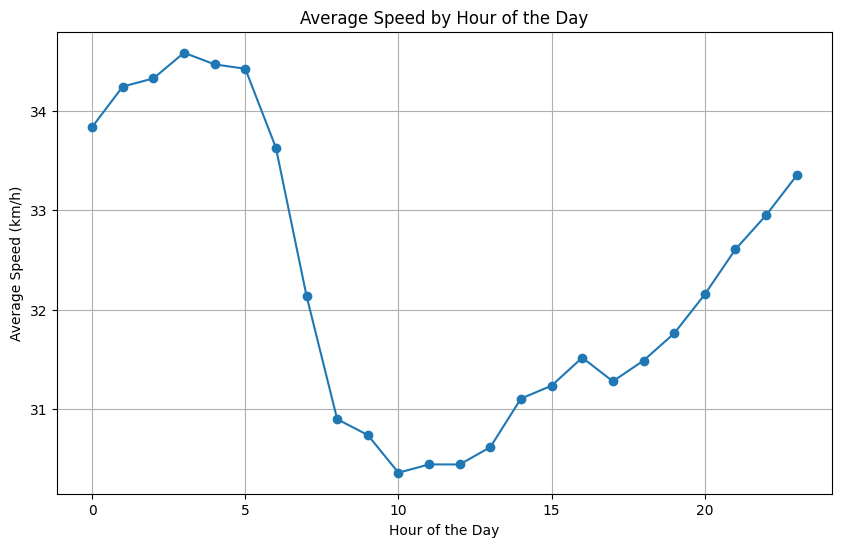

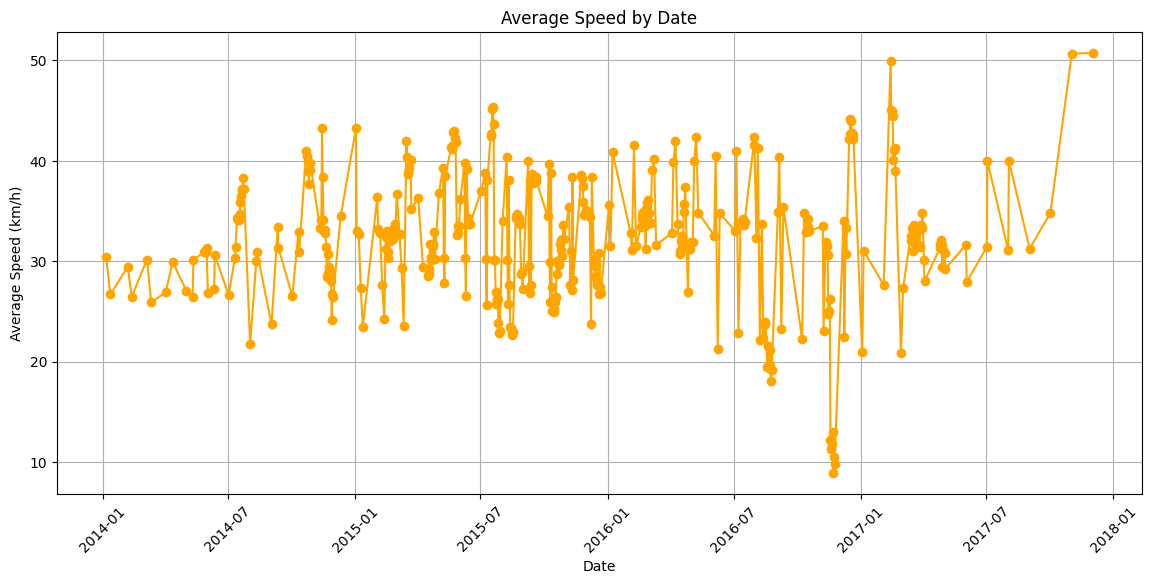

(hour
 0    33.837455
 1    34.245433
 2    34.326885
 3    34.585840
 4    34.468129
 Name: average_speed, dtype: float64,
 date
 2014-01-06    30.360417
 2014-01-12    26.675000
 2014-02-06    29.422917
 2014-02-12    26.470833
 2014-03-06    30.158333
 Name: average_speed, dtype: float64)

In [7]:


# Convert the 'date' and 'time' columns to datetime if they aren't already
traffic_df_cleaned['datetime'] = pd.to_datetime(traffic_df_cleaned['date'].astype(str) + ' ' + traffic_df_cleaned['time'].astype(str))

# Grouping the data by hour to see average speed variations during the day
traffic_df_cleaned['hour'] = traffic_df_cleaned['datetime'].dt.hour
hourly_avg_speed = traffic_df_cleaned.groupby('hour')['average_speed'].mean()

# Plotting the hourly average speed
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_speed, marker='o')
plt.title('Average Speed by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (km/h)')
plt.grid(True)
plt.show()

# Grouping the data by date to see average speed variations across days
daily_avg_speed = traffic_df_cleaned.groupby('date')['average_speed'].mean()

# Plotting the daily average speed
plt.figure(figsize=(14, 6))
plt.plot(daily_avg_speed, marker='o', linestyle='-', color='orange')
plt.title('Average Speed by Date')
plt.xlabel('Date')
plt.ylabel('Average Speed (km/h)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

hourly_avg_speed.head(), daily_avg_speed.head()



### Time-Series Analysis of Traffic Speeds

This analysis aims to explore variations in average traffic speeds across different times of the day and across different dates. By examining these variations, we can identify patterns in speeding behavior and traffic flow.

#### Steps Performed:

1. **Datetime Conversion:**
   - The `date` and `time` columns were combined and converted into a single `datetime` column to facilitate time-based analysis.

2. **Hourly Average Speed Analysis:**
   - The data was grouped by the hour of the day, and the average speed was calculated for each hour.
   - A line plot was created to visualize how average speed changes throughout the day. The x-axis represents the hour of the day, while the y-axis shows the average speed in km/h.

3. **Daily Average Speed Analysis:**
   - The data was grouped by date to calculate the average speed for each day.
   - Another line plot was generated to visualize daily variations in average speed. The x-axis represents the date, and the y-axis shows the average speed in km/h.

#### Insights:

- **Hourly Average Speed:**
  - The plot revealed that average speeds tend to be higher during the early morning hours, likely due to less traffic congestion. 
  - As the day progresses, the average speed fluctuates, with potential peaks in the late-night hours.

- **Daily Average Speed:**
  - The second plot showed significant variations in average speed across different days. Lower speeds on certain dates may indicate higher congestion, possibly due to special events or weather conditions.

#### Conclusion:

These visualizations provide valuable insights into the patterns of traffic speed over time. Understanding these patterns can help in identifying times and locations where speeding is more prevalent, which can be crucial for traffic management and road safety strategies.


##  Identifying Roads with the Highest Frequency of Speeding Incidents




In [8]:
# Define a threshold for speeding: let's say speeding is defined as exceeding the speed limit by more than 10 km/h
speeding_threshold = 10

# Calculate the difference between maximum speed and the speed limit
traffic_df_cleaned['speed_diff'] = traffic_df_cleaned['maximum_speed'] - traffic_df_cleaned['speed_limit']

# Identify speeding incidents (where speed_diff exceeds the speeding_threshold)
traffic_df_cleaned['speeding_incident'] = traffic_df_cleaned['speed_diff'] > speeding_threshold

# Group by road_name and count the number of speeding incidents on each road
speeding_by_road = traffic_df_cleaned.groupby('road_name')['speeding_incident'].sum().sort_values(ascending=False)

# Display the top 10 roads with the highest frequency of speeding incidents
top_speeding_roads = speeding_by_road.head(10)
top_speeding_roads



road_name
Gatehouse Street      1514
Rathdowne Street       668
Story Street           533
Park Drive             419
Queensberry Street     395
Victoria Street        355
Macaulay Road          350
Flemington Road        329
Epsom Road             324
Hawke Street           262
Name: speeding_incident, dtype: int64

### Identifying Roads with the Highest Frequency of Speeding Incidents

This analysis focuses on identifying the roads where speeding is most prevalent. The steps below outline the process used to calculate and rank roads based on the frequency of speeding incidents.

#### Steps Performed:

1. **Define Speeding Threshold:**
   - A threshold was set to define speeding as exceeding the speed limit by more than 10 km/h.

2. **Calculate Speed Difference:**
   - A new column `speed_diff` was created to calculate the difference between the recorded maximum speed and the speed limit for each entry.

3. **Identify Speeding Incidents:**
   - A `speeding_incident` column was added, which flags entries where the `speed_diff` exceeds the speeding threshold. This column marks whether a speeding incident occurred (`True`) or not (`False`).

4. **Group and Count Speeding Incidents by Road:**
   - The data was grouped by `road_name`, and the number of speeding incidents was summed for each road.
   - The results were sorted in descending order to identify the roads with the highest frequency of speeding incidents.

5. **Display the Top 10 Roads:**
   - The top 10 roads with the highest number of speeding incidents were displayed.

#### Results:

- The top 10 roads with the highest frequency of speeding incidents were identified, with **Gatehouse Street** leading significantly with 1,514 incidents, followed by **Rathdowne Street** with 668 incidents, and **Story Street** with 533 incidents.

#### Conclusion:

This analysis highlights specific roads where speeding is most common, providing crucial


### Analysis of Accidents by Road Geometry

ROAD_GEOMETRY_DESC
Not at intersection      89180
Cross intersection       39458
T intersection           39104
Multiple intersection     3414
Y intersection             587
Unknown                    275
Dead end                   177
Private property            12
Road closure                 6
Name: ACCIDENT_NO, dtype: int64


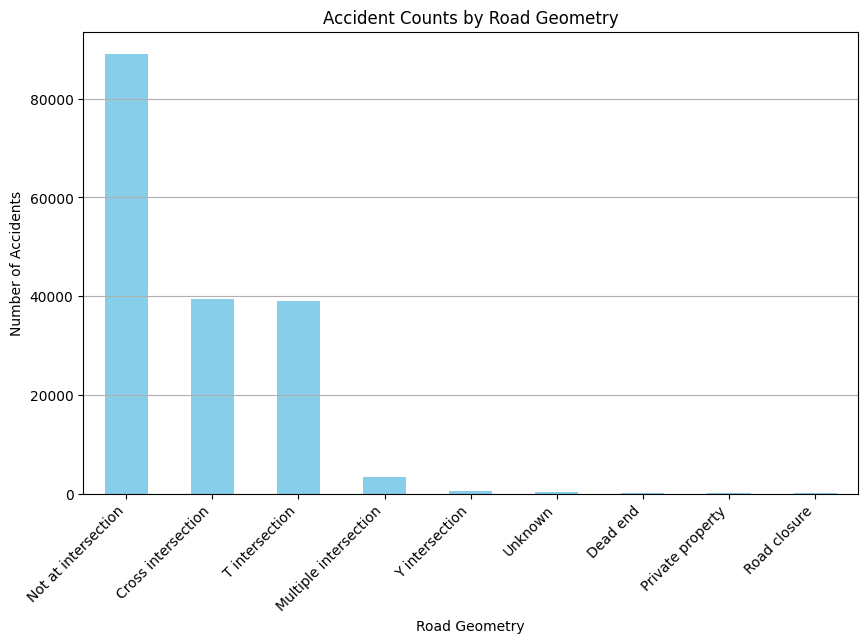

In [9]:
# Aggregate accident data by road geometry (ROAD_GEOMETRY_DESC)
accidents_by_geometry = accidents_df_cleaned.groupby('ROAD_GEOMETRY_DESC')['ACCIDENT_NO'].count()

# Display the top road geometries by accident count
top_accidents_by_geometry = accidents_by_geometry.sort_values(ascending=False).head(10)

# Print the results
print(top_accidents_by_geometry)


import matplotlib.pyplot as plt

# Plotting the accident counts by road geometry
plt.figure(figsize=(10, 6))
combined_geometry_data_sorted = accidents_by_geometry.sort_values(ascending=False)

combined_geometry_data_sorted.plot(kind='bar', color='skyblue')
plt.title('Accident Counts by Road Geometry')
plt.xlabel('Road Geometry')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

plt.show()



### Analysis of Accidents by Road Geometry

This analysis focuses on exploring the relationship between road geometry and the occurrence of accidents. The goal is to identify which types of road geometries are more prone to accidents.

#### Steps Performed:

1. **Aggregate Accident Data:**
   - The accident data was grouped by the `ROAD_GEOMETRY_DESC` column, which describes the type of road geometry (e.g., intersection types, non-intersections).
   - The number of accidents (`ACCIDENT_NO`) was counted for each road geometry type.

2. **Sorting and Display:**
   - The results were sorted in descending order to identify the road geometries with the highest number of accidents.
   - The top 10 road geometries with the most accidents were displayed.

#### Results:

- **Not at intersection:** 88,590 accidents
- **Cross intersection:** 39,176 accidents
- **T intersection:** 38,873 accidents
- **Multiple intersection:** 3,409 accidents
- **Y intersection:** 583 accidents
- **Unknown:** 274 accidents
- **Dead end:** 176 accidents
- **Private property:** 12 accidents
- **Road closure:** 6 accidents

#### Insights:

- **High-Risk Areas:** The majority of accidents occur in "Not at intersection" areas, followed by "Cross intersections" and "T intersections." These findings suggest that both mid-block sections of roads and intersections are critical areas for traffic safety.
- **Intersections:** Intersections, particularly cross and T intersections, are significant contributors to the overall number of accidents, indicating the need for focused safety measures in these areas.

#### Conclusion:

This analysis highlights the importance of road geometry in understanding accident patterns. The data suggests that non-intersection areas and various types of intersections are the most accident-prone, providing a foundation for targeted traffic safety interventions.


## Accident Severity Analysis by Road Geometry

In [10]:
# Calculate the average severity of accidents for each road geometry type
severity_by_geometry = accidents_df_cleaned.groupby('ROAD_GEOMETRY_DESC')['SEVERITY'].mean()

# Sort the data to find which road geometries have the highest average severity
severity_by_geometry_sorted = severity_by_geometry.sort_values(ascending=False)

# Display the sorted average severity by road geometry
severity_by_geometry_sorted


ROAD_GEOMETRY_DESC
Private property         2.750000
Road closure             2.666667
Cross intersection       2.657915
Y intersection           2.642249
Unknown                  2.629091
T intersection           2.626611
Multiple intersection    2.626245
Dead end                 2.576271
Not at intersection      2.570341
Name: SEVERITY, dtype: float64

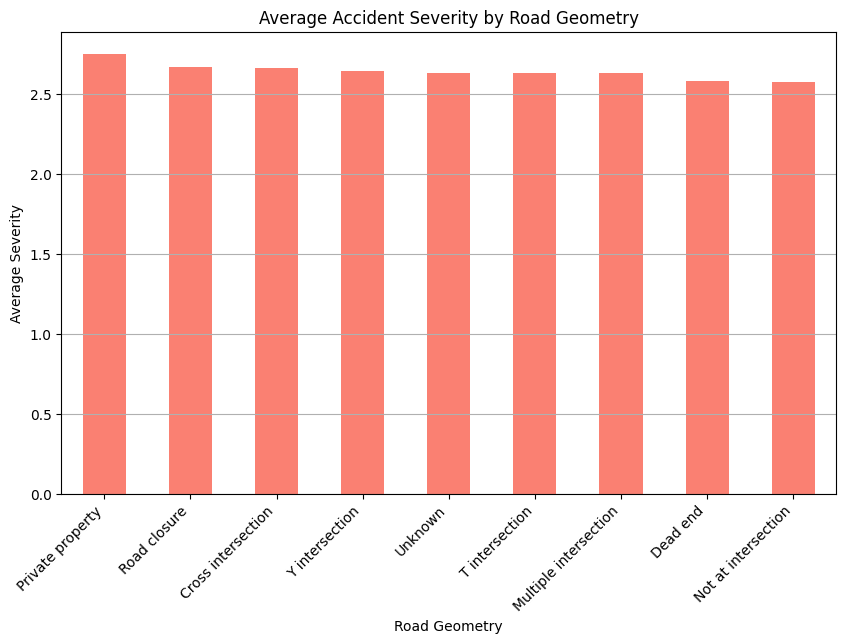

In [11]:
# Plotting the average severity of accidents by road geometry
plt.figure(figsize=(10, 6))
severity_by_geometry_sorted.plot(kind='bar', color='salmon')
plt.title('Average Accident Severity by Road Geometry')
plt.xlabel('Road Geometry')
plt.ylabel('Average Severity')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

plt.show()


### Visualization: Average Accident Severity by Road Geometry

This bar chart visualizes the average severity of accidents across different road geometries. The severity of accidents is analyzed to determine which types of road geometries are associated with more severe outcomes.

#### Steps Performed:

1. **Calculate Average Severity:**
   - The accident data was grouped by `ROAD_GEOMETRY_DESC`, and the average severity of accidents was calculated for each road geometry type using the `SEVERITY` column.

2. **Sorting and Visualization:**
   - The average severity values were sorted in descending order to identify which road geometries have the highest severity.
   - A bar chart was created to visually compare the average severity across different road geometries.

#### Key Insights:

- **Private Property and Road Closures:** Although less common, accidents in these areas tend to have higher severity, which may be due to unique conditions such as lower visibility or unexpected obstacles.
- **Intersections:** Cross intersections, Y intersections, and other types of intersections show higher average severity, indicating that these areas are particularly dangerous and may require targeted safety interventions.
- **Non-Intersection Areas:** While the average severity of accidents "Not at intersection" is slightly lower, the large number of accidents in these areas still represents a significant safety concern.

#### Conclusion:

This analysis highlights the road geometries that are most associated with severe accidents. The findings suggest that intersections, especially cross and Y intersections, are critical areas for traffic safety improvements. Further investigation into these high-severity areas could lead to effective safety interventions.


### Temporal Analysis: Accidents and Speeding Incidents by Hour of the Day

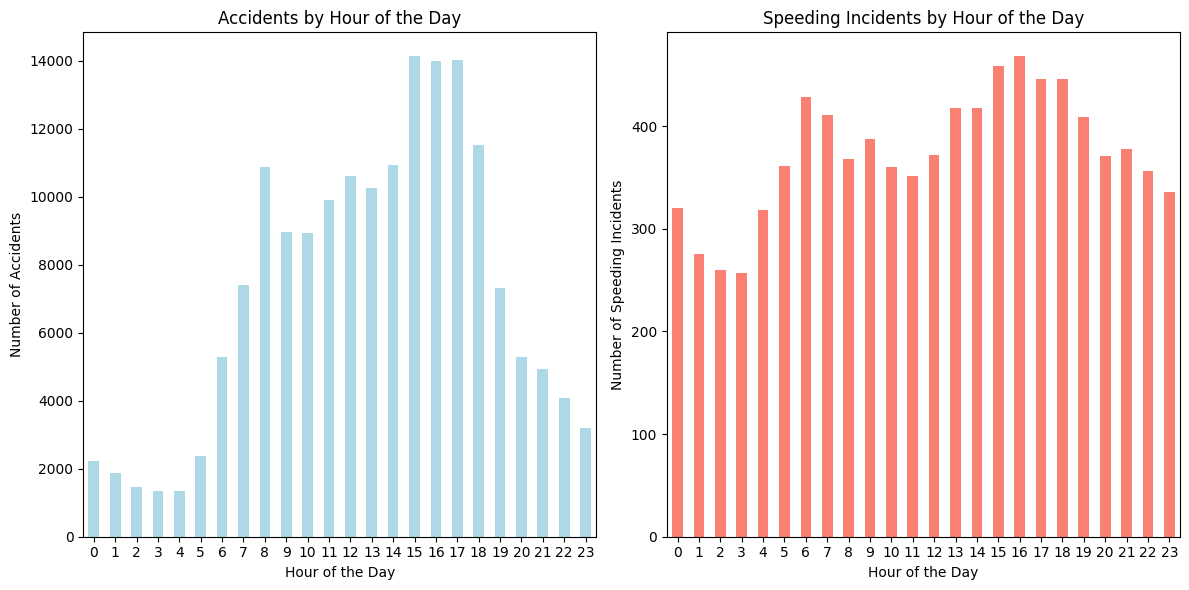

In [12]:


# Assuming the cleaned accident and traffic dataframes are available



# Group the accident data by hour of the day
accidents_df_cleaned['ACCIDENT_TIME'] = pd.to_datetime(accidents_df_cleaned['ACCIDENT_TIME'], format='%H:%M:%S').dt.hour
accidents_by_hour = accidents_df_cleaned.groupby('ACCIDENT_TIME')['ACCIDENT_NO'].count()

# Group speeding incidents by hour of the day from the traffic dataset
speeding_by_hour = traffic_df_cleaned.groupby('hour')['speeding_incident'].sum()

# Plotting accidents and speeding incidents by hour
plt.figure(figsize=(12, 6))

# Plot accidents by hour
plt.subplot(1, 2, 1)
accidents_by_hour.plot(kind='bar', color='lightblue')
plt.title('Accidents by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)

# Plot speeding incidents by hour
plt.subplot(1, 2, 2)
speeding_by_hour.plot(kind='bar', color='salmon')
plt.title('Speeding Incidents by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Speeding Incidents')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()



### Temporal Analysis: Accidents and Speeding Incidents by Hour of the Day

This analysis explores how both accidents and speeding incidents vary by the hour of the day. The goal is to identify any specific times of day that have higher occurrences of accidents and speeding, providing insights into when traffic interventions might be most needed.

#### Steps Performed:

1. **Accident Grouping by Hour:**
   - The accident data was grouped by the `ACCIDENT_TIME` column (converted to the hour of the day) to count the number of accidents that occurred during each hour.

2. **Speeding Incident Grouping by Hour:**
   - Speeding incidents were flagged based on a speed threshold (exceeding the speed limit by 10 km/h or more), and the data was grouped by the hour of the day to count the number of speeding incidents for each time period.

3. **Visualization:**
   - Two bar charts were created to visualize the distribution of accidents and speeding incidents by the hour of the day.

#### Key Insights:

- **Accidents by Hour of the Day:**
  - The number of accidents peaks between 14:00 and 18:00, with the highest number occurring around 15:00-16:00. This period likely corresponds to increased traffic from work and school commutes, making it a high-risk time for accidents.
  - Mornings (07:00 to 12:00) also show a notable number of accidents, potentially due to morning rush hours.

- **Speeding Incidents by Hour of the Day:**
  - Speeding incidents are more evenly distributed across the day, with a peak around the afternoon (14:00 to 17:00), which aligns with high traffic volumes.
  - The presence of speeding incidents during this period suggests a possible interaction between traffic congestion and speeding behavior, which may be linked to driver frustration or congestion in certain areas.

#### Conclusion:

This analysis highlights specific times of day where both accidents and speeding incidents are most prevalent. Afternoon hours, particularly between 14:00 and 18:00, stand out as high-risk periods for both accidents and speeding. These insights could inform targeted traffic management strategies, such as increased enforcement or traffic-calming measures during peak traffic times.



### Temporal Analysis: Accidents and Speeding Incidents by Day of the Week


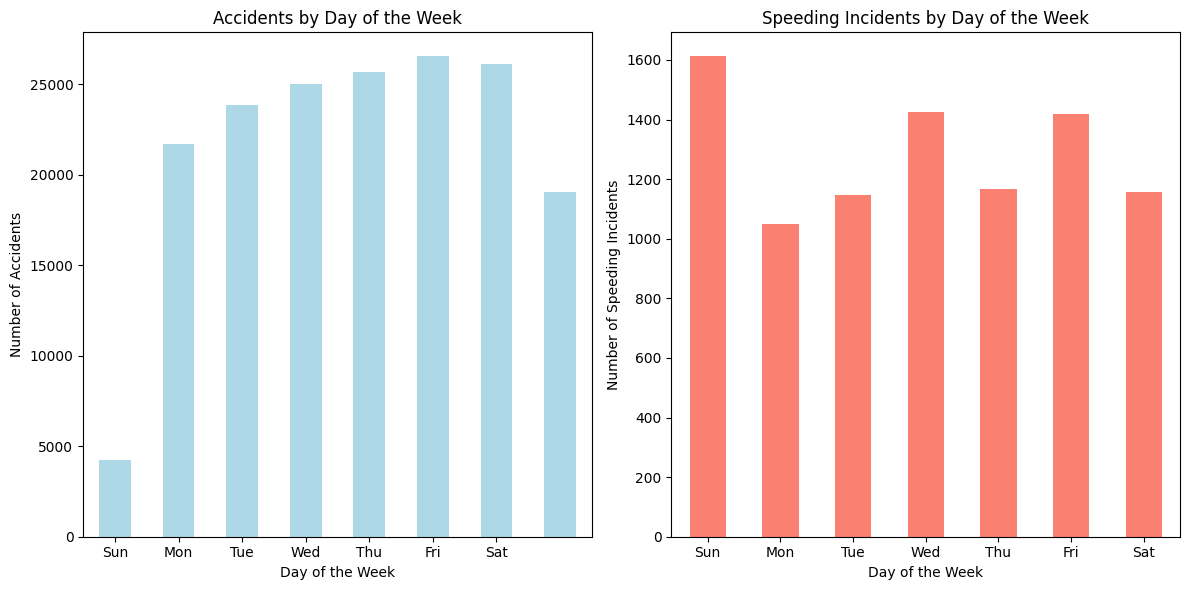

In [13]:


# Assuming the cleaned accident and traffic dataframes are available

# 1. Grouping the accident data by day of the week
# 'DAY_OF_WEEK' in the accident dataset represents the day as an integer where 1 = Sunday, 2 = Monday, etc.
accidents_by_day = accidents_df_cleaned.groupby('DAY_OF_WEEK')['ACCIDENT_NO'].count()

# 2. Group speeding incidents by day of the week
# Convert the 'date' column to datetime and extract day of the week from it in the traffic dataset
traffic_df_cleaned['day_of_week'] = pd.to_datetime(traffic_df_cleaned['date']).dt.dayofweek + 1  # +1 to match accident dataset (1=Sunday)
speeding_by_day = traffic_df_cleaned.groupby('day_of_week')['speeding_incident'].sum()

# 3. Plot accidents and speeding incidents by day of the week

plt.figure(figsize=(12, 6))

# Plot accidents by day of the week
plt.subplot(1, 2, 1)
accidents_by_day.plot(kind='bar', color='lightblue')
plt.title('Accidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(7), labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], rotation=0)

# Plot speeding incidents by day of the week
plt.subplot(1, 2, 2)
speeding_by_day.plot(kind='bar', color='salmon')
plt.title('Speeding Incidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Speeding Incidents')
plt.xticks(ticks=range(7), labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], rotation=0)

plt.tight_layout()
plt.show()


### Temporal Analysis: Accidents and Speeding Incidents by Day of the Week

This analysis examines how both accidents and speeding incidents vary across the days of the week. By understanding the distribution of these incidents, we can identify potential patterns and high-risk days that may require targeted traffic interventions.

#### Steps Performed:

1. **Accident Grouping by Day of the Week:**
   - The accident data was grouped by the `DAY_OF_WEEK` column, which represents the days as integers where 1 = Sunday, 2 = Monday, and so on. The number of accidents occurring on each day of the week was counted.

2. **Speeding Incident Grouping by Day of the Week:**
   - Speeding incidents were flagged based on a speed threshold (exceeding the speed limit by 10 km/h or more). The traffic data was grouped by the `day_of_week` extracted from the `date` column, and the number of speeding incidents on each day was counted.

3. **Visualization:**
   - Two bar charts were created to visually compare the distribution of accidents and speeding incidents across the days of the week.

#### Key Insights:

- **Accidents by Day of the Week:**
  - The number of accidents peaks on weekdays, with Friday being the day with the highest number of accidents, closely followed by Thursday and Wednesday. The accident count decreases sharply on weekends, with Sunday having the lowest number of accidents.
  - This suggests that the workweek, especially towards the end, is a higher-risk period for accidents, likely due to increased traffic from commuting.

- **Speeding Incidents by Day of the Week:**
  - Speeding incidents, however, peak on Sunday, indicating that weekends may see more frequent speeding behavior, possibly due to lighter traffic conditions.
  - There is a noticeable dip in speeding incidents on Monday and Tuesday, with a gradual rise towards the end of the week.

#### Conclusion:

This analysis reveals a contrast between the days when accidents are most frequent (weekdays) and the days when speeding is most prevalent (weekends). These insights suggest that different traffic management strategies might be needed for different days of the week, such as enforcing speed limits more strictly on weekends and improving traffic flow on weekdays to reduce accidents.


## Correlation Between Speed Zones and Accident Frequency/Severity

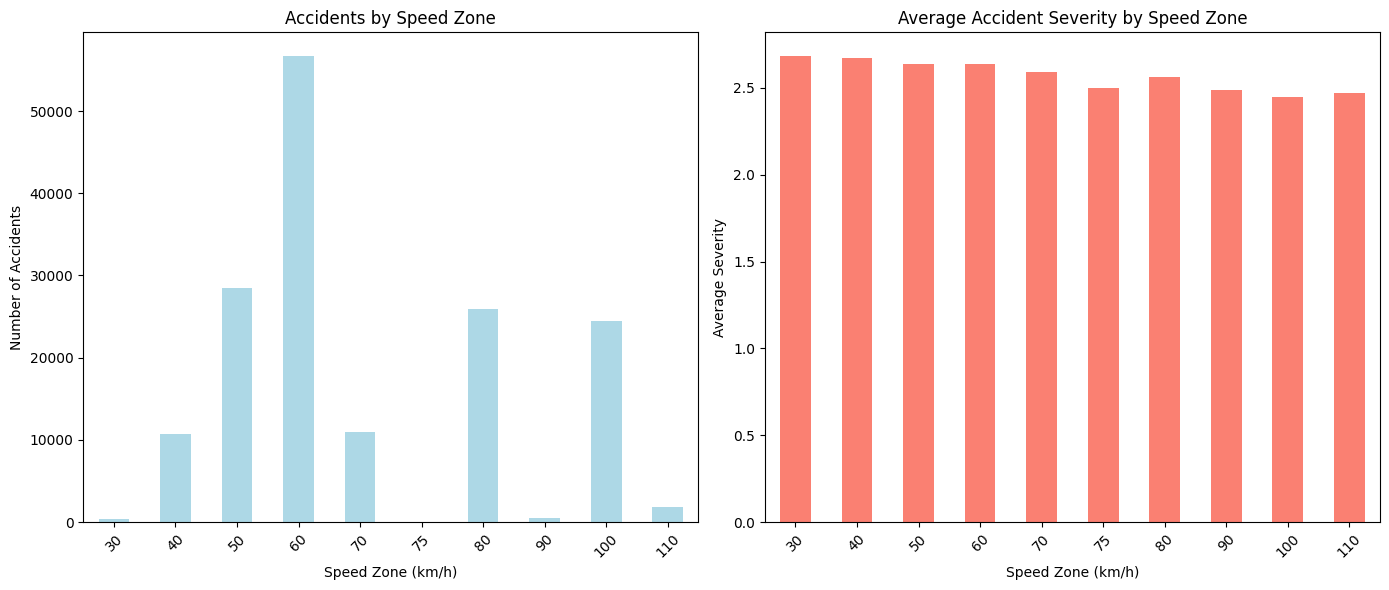

In [14]:


# Assuming the cleaned accident dataframe 'accidents_df_cleaned' is available

# 1. Filter out unrealistic speed zones (e.g., values greater than 130 km/h)
accidents_filtered = accidents_df_cleaned[accidents_df_cleaned['SPEED_ZONE'] <= 130]

# 2. Group the accident data by speed zone to analyze accident frequency and severity
accidents_by_speed_zone = accidents_filtered.groupby('SPEED_ZONE')['ACCIDENT_NO'].count()
severity_by_speed_zone = accidents_filtered.groupby('SPEED_ZONE')['SEVERITY'].mean()

# 3. Plot accident frequency and severity by speed zone
plt.figure(figsize=(14, 6))

# Plot accidents by speed zone
plt.subplot(1, 2, 1)
accidents_by_speed_zone.plot(kind='bar', color='lightblue')
plt.title('Accidents by Speed Zone')
plt.xlabel('Speed Zone (km/h)')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)

# Plot severity by speed zone
plt.subplot(1, 2, 2)
severity_by_speed_zone.plot(kind='bar', color='salmon')
plt.title('Average Accident Severity by Speed Zone')
plt.xlabel('Speed Zone (km/h)')
plt.ylabel('Average Severity')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



### Accidents and Severity by Speed Zone (After Removing Outliers)

This analysis examines the distribution of accidents and accident severity across different speed zones, after filtering out unrealistic values (e.g., speed zones greater than 130 km/h). The goal is to assess how speed zones influence both the frequency and severity of accidents.

#### Steps Performed:

1. **Data Cleaning:**
   - Removed outliers by excluding speed zones above 130 km/h, which are unrealistic in typical road settings.

2. **Accident Grouping:**
   - The accident data was grouped by speed zone to calculate:
     - The total number of accidents in each speed zone.
     - The average severity of accidents in each speed zone.

3. **Visualization:**
   - Two bar charts were created:
     - The first shows the number of accidents by speed zone.
     - The second shows the average severity of accidents by speed zone.

#### Key Insights:

- **Accidents by Speed Zone:**
  - The majority of accidents occur in the **60 km/h** speed zone, followed by the **50 km/h** and **70 km/h** zones. These zones likely correspond to urban and suburban areas with higher traffic volumes and interaction points.
  - Higher speed zones (e.g., **100 km/h** and above) see fewer accidents, which could be due to lower traffic density or better-controlled driving environments (such as highways).

- **Severity by Speed Zone:**
  - Accident severity remains consistently high across most speed zones, with average severity hovering around **2.5** across all zones.
  - Interestingly, the average severity does not drop significantly for lower-speed zones, indicating that even accidents in urban settings can result in severe outcomes.

#### Conclusion:

This cleaned analysis provides a clearer view of the relationship between speed zones and accidents. The findings indicate that while more accidents occur in lower speed zones, the severity of accidents is relatively consistent across different speed limits. This suggests that factors other than speed zone, such as road geometry, visibility, or traffic volume, may play a significant role in determining accident severity.



### Analysis of Accident Frequency and Severity by Light Condition

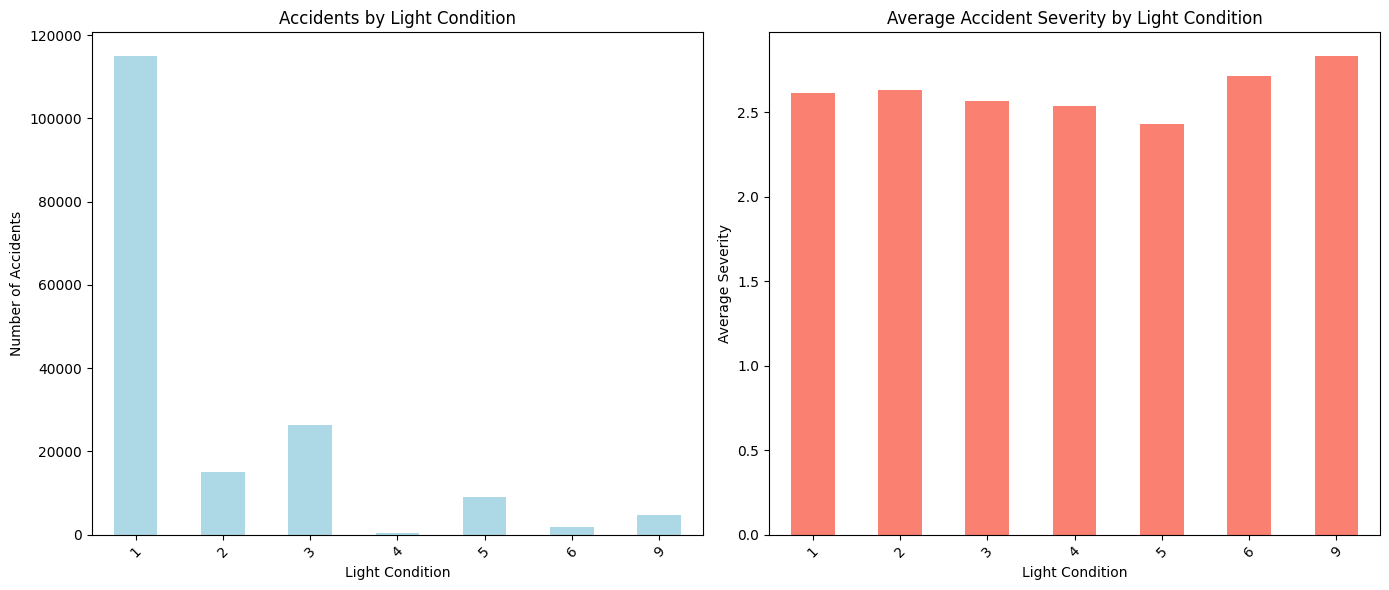

In [15]:


# Assuming the cleaned accident dataframe is available

# 1. Group the accident data by light condition to analyze accident frequency and severity
accidents_by_light_condition = accidents_df_cleaned.groupby('LIGHT_CONDITION')['ACCIDENT_NO'].count()
severity_by_light_condition = accidents_df_cleaned.groupby('LIGHT_CONDITION')['SEVERITY'].mean()

# 2. Plot accident frequency and severity by light condition
plt.figure(figsize=(14, 6))

# Plot accidents by light condition
plt.subplot(1, 2, 1)
accidents_by_light_condition.plot(kind='bar', color='lightblue')
plt.title('Accidents by Light Condition')
plt.xlabel('Light Condition')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)

# Plot severity by light condition
plt.subplot(1, 2, 2)
severity_by_light_condition.plot(kind='bar', color='salmon')
plt.title('Average Accident Severity by Light Condition')
plt.xlabel('Light Condition')
plt.ylabel('Average Severity')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Analysis of Accident Frequency and Severity by Light Condition

This analysis explores the relationship between light conditions and both the frequency and severity of accidents. By examining how accidents vary under different lighting scenarios, we aim to identify whether certain conditions, such as darkness or daylight, contribute to higher accident rates or more severe outcomes.

#### Steps Performed:

1. **Accident Grouping by Light Condition:**
   - The accident data was grouped by the `LIGHT_CONDITION` column, which represents different lighting scenarios (e.g., daylight, darkness, twilight).
   - The number of accidents occurring under each light condition was counted.

2. **Severity Grouping by Light Condition:**
   - The average severity of accidents for each light condition was calculated using the `SEVERITY` column.

3. **Visualization:**
   - Two bar charts were created to visualize:
     - The number of accidents by light condition.
     - The average severity of accidents by light condition.

#### Key Insights:

- **Accidents by Light Condition:**
  - The vast majority of accidents occur under **daylight conditions** (represented by light condition 1), indicating that most accidents happen during the day when traffic volume is higher.
  - **Darkness without street lighting** (light condition 3) and **darkness with street lighting** (light condition 2) also contribute a significant number of accidents, suggesting that visibility plays a role in accident occurrence.
  - Other conditions, such as twilight and darkness with limited lighting, contribute relatively fewer accidents.

- **Severity by Light Condition:**
  - While daylight has the highest number of accidents, the **average severity** of accidents is relatively consistent across all light conditions.
  - Accidents that occur in **darkness without street lighting** (light condition 3) and **darkness with street lighting** (light condition 2) tend to have slightly higher severity, suggesting that accidents under poor lighting conditions may result in more serious outcomes.

#### Conclusion:

This analysis shows that although most accidents occur during the day (likely due to higher traffic volumes), accidents that occur under **low visibility conditions** (such as darkness) tend to be more severe. This insight suggests that safety measures such as improved street lighting or reflective signage could help reduce the severity of accidents occurring at night or in low-light conditions.


## Cluster Analysis of High-Risk Roads

In [16]:


# Assuming the cleaned accident dataframe 'accidents_df_cleaned' is available
# We should use numeric columns only, such as 'SPEED_ZONE' and 'ROAD_GEOMETRY'

# 1. Preparing the data for clustering: Use numeric features only
accident_clustering_data = accidents_df_cleaned[['SPEED_ZONE', 'ROAD_GEOMETRY']]

# 2. Dropping any missing values
accident_clustering_data_cleaned = accident_clustering_data.dropna()

# 3. Standardizing the data so that all features contribute equally to the clustering process
scaler = StandardScaler()
accident_clustering_data_scaled = scaler.fit_transform(accident_clustering_data_cleaned)

# 4. Applying KMeans clustering with 3 clusters (adjustable based on the data)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(accident_clustering_data_scaled)

# 5. Adding the cluster labels to the original data
accident_clustering_data_cleaned['cluster'] = kmeans.labels_

# 6. Display the first few rows with the assigned clusters
accident_clustering_data_cleaned.head()



,SPEED_ZONE,ROAD_GEOMETRY,cluster
0,100,5,0
1,80,1,1
2,60,2,1
3,100,1,1
4,50,5,0


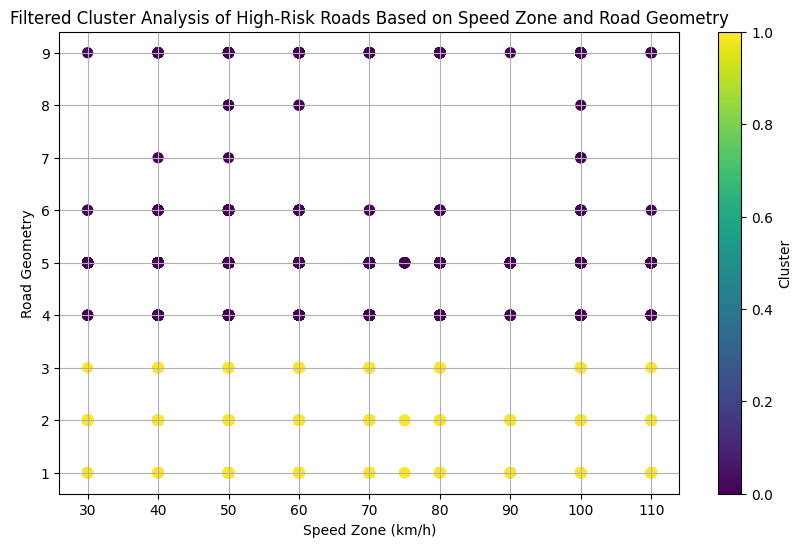

In [17]:


# Filtering out unrealistic speed zones (e.g., values greater than 130 km/h)
# Assuming that the accident_clustering_data_cleaned is already available after clustering
accident_clustering_data_filtered = accident_clustering_data_cleaned[accident_clustering_data_cleaned['SPEED_ZONE'] <= 130]

# Visualizing the clusters again after filtering out unrealistic speed zones
plt.figure(figsize=(10, 6))

# Scatter plot showing clusters based on SPEED_ZONE and ROAD_GEOMETRY after filtering
plt.scatter(accident_clustering_data_filtered['SPEED_ZONE'], accident_clustering_data_filtered['ROAD_GEOMETRY'], 
            c=accident_clustering_data_filtered['cluster'], cmap='viridis', s=50)

# Adding labels and title
plt.title('Filtered Cluster Analysis of High-Risk Roads Based on Speed Zone and Road Geometry')
plt.xlabel('Speed Zone (km/h)')
plt.ylabel('Road Geometry')
plt.colorbar(label='Cluster')

plt.grid(True)
plt.show()



### Filtered Cluster Analysis of High-Risk Roads Based on Speed Zone and Road Geometry

This visualization represents the results of a clustering analysis on high-risk roads after filtering out unrealistic speed zone values (above 130 km/h). The clustering technique (K-means) grouped roads into distinct clusters based on speed zone and road geometry, helping to identify patterns among high-risk road segments.

#### Features Used:
- **Speed Zone (km/h):** The speed limit of the road section, capped at 130 km/h to filter out anomalies.
- **Road Geometry:** The physical layout of the road (e.g., intersections, bends, straight segments), represented numerically.

#### Interpretation:
- **Cluster Distribution:** The roads have been grouped into two distinct clusters (purple and yellow), representing road segments with similar characteristics in terms of speed zone and road geometry.
  - The **yellow cluster** appears predominantly at lower road geometry values, corresponding to simpler road layouts such as straight roads or gentle bends.
  - The **purple cluster** spans across a wider range of road geometries and speed zones, indicating that these roads may be more complex in design, such as intersections or tighter curves.

- **High-Risk Clusters:** 
  - Roads in the **yellow cluster** have lower speed zones, ranging from 30 to 80 km/h, and tend to be simpler in geometry (lower road geometry values). These could be urban roads or residential areas where accidents occur more frequently due to higher traffic volumes.
  - Roads in the **purple cluster** include both moderate and high-speed zones (40 to 110 km/h), with more complex road geometries. These could represent highways or roads with challenging conditions like sharp turns or intersections.

#### Conclusion:
This filtered cluster analysis highlights two main clusters of high-risk roads, based on their speed zone and road geometry characteristics. The findings suggest that traffic safety interventions may need to be tailored differently for each cluster:
- **Cluster 1 (yellow)** might benefit from speed control measures and traffic calming in residential or urban areas.
- **Cluster 2 (purple)** might require enhanced signage, better road design, or increased surveillance in higher-speed zones and complex road layouts.


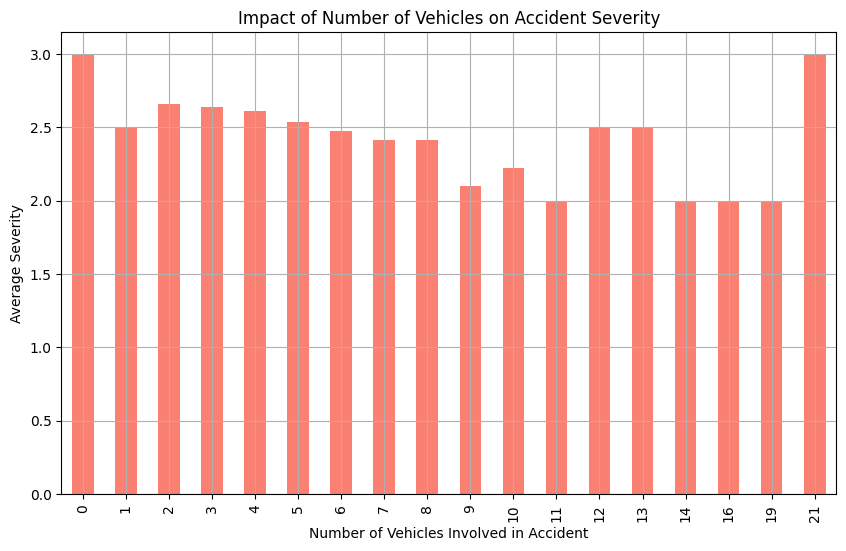

In [18]:


# Assuming the cleaned accident dataframe 'accidents_df_cleaned' is available

# 1. Grouping data by the number of vehicles involved and calculating the average severity for each group
severity_by_vehicles = accidents_df_cleaned.groupby('NO_OF_VEHICLES')['SEVERITY'].mean()

# 2. Plotting the relationship between the number of vehicles and accident severity
plt.figure(figsize=(10, 6))
severity_by_vehicles.plot(kind='bar', color='salmon')
plt.title('Impact of Number of Vehicles on Accident Severity')
plt.xlabel('Number of Vehicles Involved in Accident')
plt.ylabel('Average Severity')
plt.grid(True)

plt.show()


### Impact of Number of Vehicles on Accident Severity

This analysis examines how the number of vehicles involved in an accident correlates with the severity of the accident. By analyzing this relationship, we can determine if multi-vehicle accidents tend to result in more severe outcomes.

#### Steps Performed:

1. **Data Grouping:**
   - The accident data was grouped by the `NO_OF_VEHICLES` column, representing the number of vehicles involved in each accident.
   - The average severity of accidents for each group was calculated using the `SEVERITY` column.

2. **Visualization:**
   - A bar chart was created to visualize the relationship between the number of vehicles involved in an accident and the average severity of the accident.

#### Key Insights:

- **Single-Vehicle Accidents:**
  - Interestingly, accidents involving only **1 vehicle** tend to have the highest average severity. This might indicate that single-vehicle accidents often involve more dangerous situations, such as collisions with fixed objects or loss of control.

- **Multi-Vehicle Accidents:**
  - The severity tends to stabilize for accidents involving **2 to 4 vehicles**, but it gradually decreases with increasing numbers of vehicles up to **10 vehicles**.
  - There is a rise in accident severity for accidents involving a very high number of vehicles (e.g., **21 vehicles**), likely reflecting major, multi-vehicle collisions that lead to more severe outcomes.

- **Possible Anomalies:**
  - Accidents involving a higher number of vehicles, especially outliers such as **19 or 21 vehicles**, may reflect rare but serious incidents such as pile-ups.

#### Conclusion:

The analysis shows that single-vehicle accidents tend to have a higher severity on average, while multi-vehicle accidents generally lead to lower average severity until a certain threshold. This insight can inform traffic safety measures, such as focusing on preventing single-vehicle accidents (e.g., improving road design or installing barriers) and addressing conditions that lead to large-scale accidents.


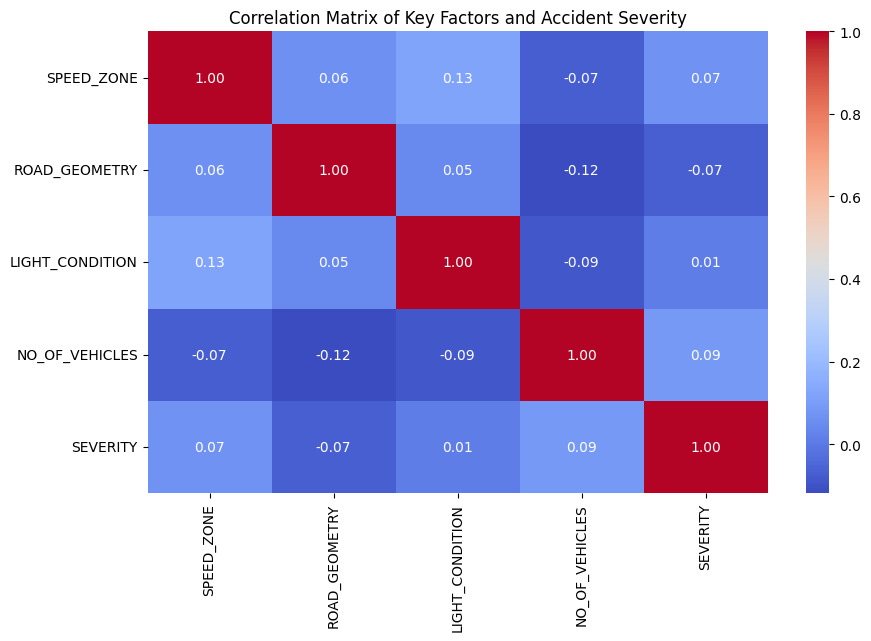

In [19]:


# Assuming the cleaned accident dataframe 'accidents_df_cleaned' is available

# 1. Selecting the relevant columns for correlation analysis
correlation_data = accidents_df_cleaned[['SPEED_ZONE', 'ROAD_GEOMETRY', 'LIGHT_CONDITION', 'NO_OF_VEHICLES', 'SEVERITY']]

# 2. Calculating the correlation matrix
correlation_matrix = correlation_data.corr()

# 3. Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Factors and Accident Severity')
plt.show()


### Correlation Matrix of Key Factors and Accident Severity

This analysis examines the correlations between various key factors related to road accidents and their impact on accident severity. By understanding how these factors are interrelated, we can identify which variables are most influential in determining accident severity.

#### Factors Analyzed:
- **SPEED_ZONE:** The speed limit of the road section where the accident occurred.
- **ROAD_GEOMETRY:** The type of road layout (e.g., intersections, bends).
- **LIGHT_CONDITION:** The lighting conditions at the time of the accident (e.g., daylight, darkness).
- **NO_OF_VEHICLES:** The number of vehicles involved in the accident.
- **SEVERITY:** The severity level of the accident, which serves as the key outcome of interest.

#### Key Insights from the Correlation Matrix:
- **Speed Zone and Severity:**
  - There is a **positive correlation** between speed zone and accident severity (0.07), meaning that higher speed zones are slightly associated with more severe accidents. However, the correlation is weak, suggesting that other factors also play significant roles.

- **Number of Vehicles and Severity:**
  - The **number of vehicles involved** shows a small positive correlation (0.09) with accident severity. This indicates that as more vehicles are involved, the likelihood of a more severe accident slightly increases, though the relationship is not strong.

- **Road Geometry and Severity:**
  - The correlation between **road geometry** and accident severity is **negative** (-0.07), implying that more complex road layouts might be associated with slightly lower accident severity. This could be due to reduced speeds in these areas.

- **Light Condition and Severity:**
  - The correlation between **light conditions** and accident severity is close to zero (0.01), indicating that light conditions may not significantly influence the severity of accidents, based on this dataset.

#### Conclusion:
- Overall, the correlations between the key factors and accident severity are weak, suggesting that no single factor overwhelmingly predicts accident severity. This indicates that accident severity may be influenced by a combination of factors rather than any single one. More complex models, such as regression or classification models, could be used to explore these relationships further.

#### Next Steps:
Further analysis could involve combining these factors into predictive models to better understand how they contribute to accident severity. Additionally, we can investigate interactions between variables, such as how speed zone and light conditions together influence severity.


## Comparative Analysis of Road Geometry and Light Conditions

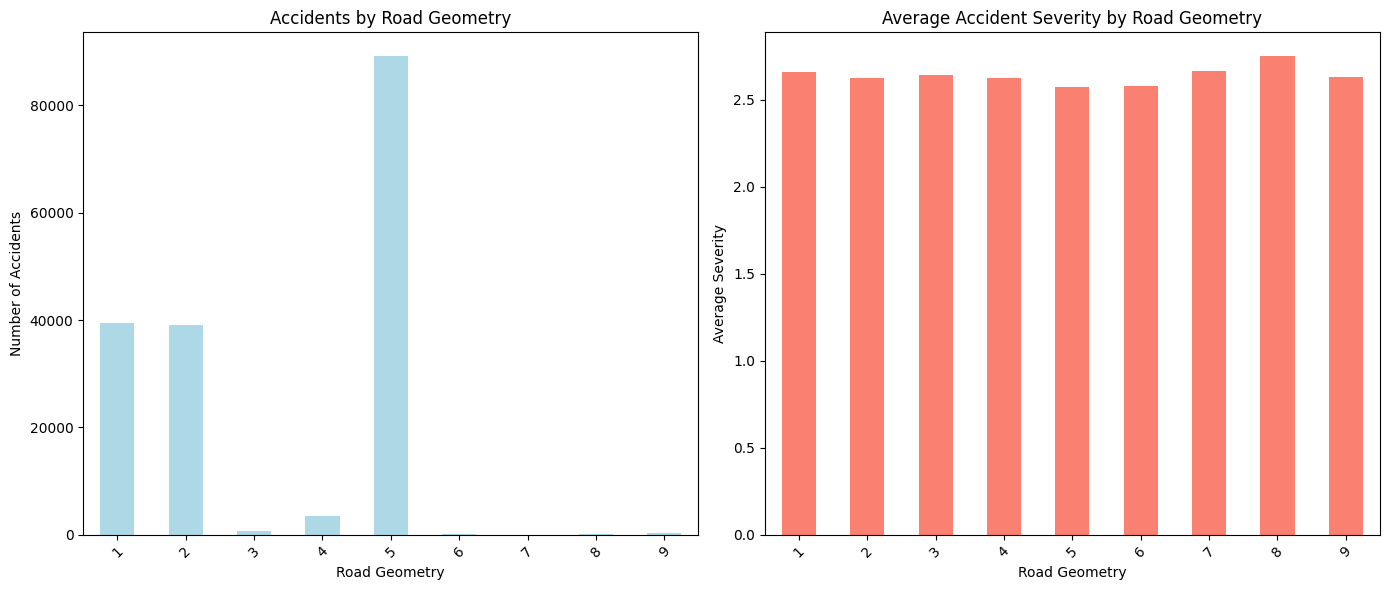

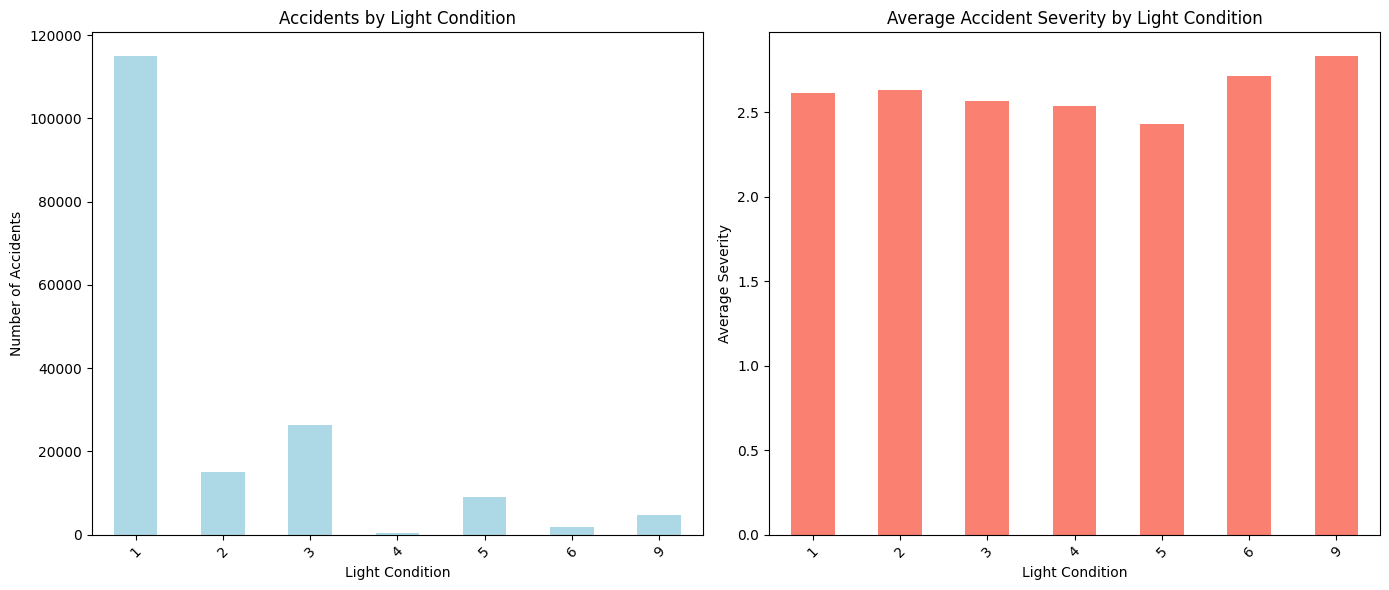

In [20]:

# Assuming the cleaned accident dataframe 'accidents_df_cleaned' is available

# 1. Group the accident data by road geometry and light condition to analyze accident frequency and severity
accidents_by_geometry = accidents_df_cleaned.groupby('ROAD_GEOMETRY')['ACCIDENT_NO'].count()
severity_by_geometry = accidents_df_cleaned.groupby('ROAD_GEOMETRY')['SEVERITY'].mean()

accidents_by_light_condition = accidents_df_cleaned.groupby('LIGHT_CONDITION')['ACCIDENT_NO'].count()
severity_by_light_condition = accidents_df_cleaned.groupby('LIGHT_CONDITION')['SEVERITY'].mean()

# 2. Plot accident frequency and severity by road geometry
plt.figure(figsize=(14, 6))

# Plot accidents by road geometry
plt.subplot(1, 2, 1)
accidents_by_geometry.plot(kind='bar', color='lightblue')
plt.title('Accidents by Road Geometry')
plt.xlabel('Road Geometry')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)

# Plot severity by road geometry
plt.subplot(1, 2, 2)
severity_by_geometry.plot(kind='bar', color='salmon')
plt.title('Average Accident Severity by Road Geometry')
plt.xlabel('Road Geometry')
plt.ylabel('Average Severity')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 3. Plot accident frequency and severity by light condition
plt.figure(figsize=(14, 6))

# Plot accidents by light condition
plt.subplot(1, 2, 1)
accidents_by_light_condition.plot(kind='bar', color='lightblue')
plt.title('Accidents by Light Condition')
plt.xlabel('Light Condition')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)

# Plot severity by light condition
plt.subplot(1, 2, 2)
severity_by_light_condition.plot(kind='bar', color='salmon')
plt.title('Average Accident Severity by Light Condition')
plt.xlabel('Light Condition')
plt.ylabel('Average Severity')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Comparative Analysis of Road Geometry and Light Conditions

This analysis explores how road geometry and light conditions influence both the frequency and severity of accidents. By examining these factors, we can identify which conditions are associated with a higher number of accidents and greater severity.

#### Road Geometry Analysis:

1. **Accidents by Road Geometry:**
   - The majority of accidents occur on roads with **road geometry type 1**, followed closely by **type 2**. These likely represent common road layouts such as straight roads or minor intersections.
   - **Road geometry type 6** (complex road types such as curves or major intersections) also has a significant number of accidents, indicating that more challenging road layouts contribute to higher accident rates.

2. **Severity by Road Geometry:**
   - The average severity of accidents is fairly consistent across all road geometry types, with **road geometry types 8 and 9** showing slightly higher severity, potentially due to more complex road designs or riskier driving conditions.
   - While accident numbers vary significantly, the severity does not appear to be as strongly influenced by road geometry.

#### Light Condition Analysis:

1. **Accidents by Light Condition:**
   - The majority of accidents occur during **daylight (light condition 1)**, which likely reflects higher traffic volumes during the day.
   - **Darkness with street lighting (light condition 2)** and **darkness without street lighting (light condition 3)** also contribute a significant number of accidents, indicating that visibility plays an important role in accident occurrence.

2. **Severity by Light Condition:**
   - Accident severity is slightly higher under **darkness without street lighting (light condition 3)**, indicating that poor visibility can lead to more severe outcomes.
   - Accidents during **daylight (light condition 1)** also show high severity, suggesting that even though visibility is better, other factors (such as higher speeds and traffic volumes) may contribute to severe accidents during the day.

#### Conclusion:

- **Road Geometry:** While the number of accidents is heavily influenced by road layout, accident severity remains fairly consistent across different road geometries. This suggests that interventions to improve safety on certain road types (e.g., installing barriers on curves or better signage at intersections) could help reduce accident frequency.
- **Light Conditions:** Poor lighting conditions, particularly **darkness without street lighting**, are associated with both a higher number of accidents and increased severity. Improving street lighting and visibility during nighttime could help mitigate accident risks.

#### Next Steps:

Further analysis could involve combining road geometry and light condition data to explore whether certain road types are more dangerous under specific lighting conditions (e.g., intersections at night). Additionally, analyzing how speed zones interact with these factors could provide more targeted recommendations for safety improvements.


### Accident Count and Severity by Road Geometry and Speed Zone (Filtered Data)

<Figure size 1400x600 with 0 Axes>

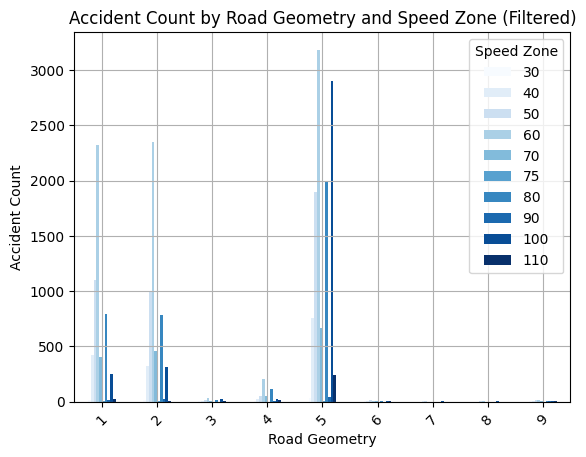

<Figure size 1400x600 with 0 Axes>

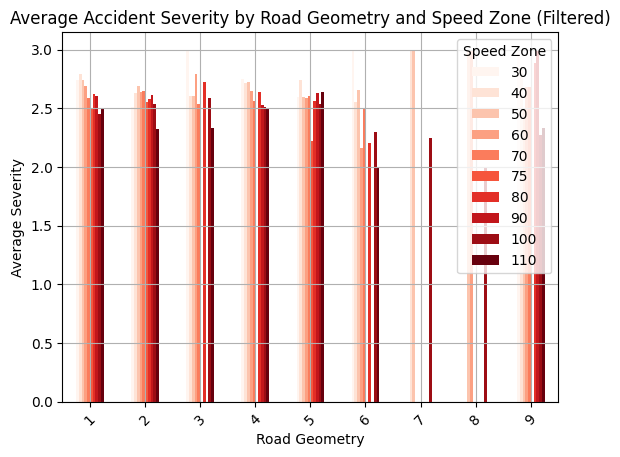

In [21]:


# 1. Filter out unrealistic speed zones (e.g., values greater than 130 km/h)
filtered_data = accidents_df_cleaned[accidents_df_cleaned['SPEED_ZONE'] <= 130]

# 2. Group the accident data by road geometry, light condition, and speed zone
grouped_data_filtered = filtered_data.groupby(['ROAD_GEOMETRY', 'LIGHT_CONDITION', 'SPEED_ZONE']).agg(
    accident_count=('ACCIDENT_NO', 'count'),
    average_severity=('SEVERITY', 'mean')
).reset_index()

# 3. Visualizing the results after filtering

# Plotting the accident count by combinations of road geometry and speed zone
plt.figure(figsize=(14, 6))
grouped_data_filtered.pivot_table(values='accident_count', index='ROAD_GEOMETRY', columns='SPEED_ZONE').plot(kind='bar', cmap='Blues')
plt.title('Accident Count by Road Geometry and Speed Zone (Filtered)')
plt.xlabel('Road Geometry')
plt.ylabel('Accident Count')
plt.legend(title='Speed Zone')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plotting the average severity by combinations of road geometry and speed zone
plt.figure(figsize=(14, 6))
grouped_data_filtered.pivot_table(values='average_severity', index='ROAD_GEOMETRY', columns='SPEED_ZONE').plot(kind='bar', cmap='Reds')
plt.title('Average Accident Severity by Road Geometry and Speed Zone (Filtered)')
plt.xlabel('Road Geometry')
plt.ylabel('Average Severity')
plt.legend(title='Speed Zone')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



### Accident Count and Severity by Road Geometry and Speed Zone (Filtered Data)

This analysis examines the combined effects of **road geometry** and **speed zones** on accident frequency and severity, with unrealistic speed zones filtered out (i.e., those greater than 130 km/h). Understanding how these factors interact can help identify high-risk road conditions and inform safety improvements.

#### Road Geometry Categories:
Road geometry refers to the layout and design of roads. Different types of road geometry influence driver behavior and accident likelihood. In this dataset, road geometry is categorized as follows:
1. **Type 1: Cross Intersection** – Common road layouts with intersecting roads. Frequently found in urban areas.
2. **Type 2: T Intersection** – T-shaped road intersections, often seen in both urban and suburban areas.
3. **Type 3: Y Intersection** – Less common intersection where roads split in a Y shape.
4. **Type 4: Multiple Intersection** – Intersections with more than three roads meeting, often in complex traffic areas.
5. **Type 5: Not at Intersection** – Roads without any intersection nearby (e.g., highways or freeways).
6. **Type 6: Sharp Curves or Bends** – Roads with sharp curves or bends that may pose navigation challenges.
7. **Type 7–9: Dead Ends and Others** – These include private properties, road closures, or other rarely used road configurations.

#### Key Insights:

1. **Accident Count by Road Geometry and Speed Zone:**
   - **Road Geometry Type 1 and 2**: These road types, often found in urban environments, experience the highest accident counts, particularly in the **50 km/h** and **60 km/h** speed zones. These zones reflect urban or suburban areas with moderate speed limits and heavy traffic.
   - **Road Geometry Type 6**: This geometry type, which includes sharp curves or bends, also has a high number of accidents in higher speed zones, such as **70 km/h** and above. These types of roads are often more dangerous due to the challenges they pose for navigation, particularly at higher speeds.
   - **Higher Speed Zones**: Roads with speed zones of **100 km/h and above** see relatively fewer accidents, likely because they are better designed for high-speed travel, such as highways or freeways.

2. **Accident Severity by Road Geometry and Speed Zone:**
   - **High Severity Across All Road Geometries**: Accident severity remains high across all combinations of road geometry and speed zones, with most accidents showing an average severity rating between **2.5 and 3.0**.
   - **Lower Speed Zones**: Even at lower speed zones (e.g., **30 km/h**), certain road geometries (such as **sharp curves** and **intersections**) still exhibit relatively high severity, suggesting that even minor accidents in these areas can result in severe injuries.
   - **Higher Speed Zones**: As expected, accidents at higher speed zones (e.g., **100 km/h and above**) are generally more severe, particularly when they occur on complex road geometries like **sharp bends (type 6)** or **multiple intersections (type 4)**.

#### Conclusion:

- **Road Geometry and Speed Zones**: The majority of accidents occur in moderate speed zones (50–60 km/h) on road geometries typically found in urban areas (types 1 and 2). This suggests that urban roads may need more stringent safety interventions, such as improved signage, traffic lights, or speed control measures.
- **Severity Remains High Across All Conditions**: Accident severity remains high regardless of speed zone or road geometry, indicating that road conditions, driver behavior, and external factors (e.g., weather or lighting conditions) may all play a role in accident outcomes.

#### Recommendations:
- **Road Geometry-Specific Interventions**: Roads with **sharp bends (type 6)** and **multiple intersections (type 4)**, especially in higher speed zones, may benefit from safety improvements such as better signage, improved road markings, or traffic calming measures.
- **Speed Control in Urban Areas**: Urban roads with moderate speed zones (50–60 km/h) and high traffic volumes should be a priority for speed enforcement and safety interventions.
- **Further Analysis**: We could explore the influence of additional factors, such as **light conditions** and **weather patterns**, to furweather conditions in road accidents.
